<a href="https://colab.research.google.com/github/SaadTazroute/JurisprudencesClassification/blob/master/01_Deep_Analysis_for_the_CASS_Data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the CASS Dataset used in this internship**




# Overview of pipeline

1. Read  data from csv file (all jurisprudences in a single file)
2. EDA: Distribution of characters
3. Text preprocessing and cleaning (output = clean corpus)
4. EDA: Distribution of document length
5. EDA: Distribution of word frequencies (detection of hapaxes ...)
6. EDA: Collocation detection (mainly bigrams ) 


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14

In [ ]:
np.set_printoptions(precision=3)

In [ ]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import re
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
from collections import defaultdict

In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Read  data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Read data from a CSV file : this will return a DataFrame object
path='/content/drive/My Drive/Freemium02.csv'
import pandas as pd
data_df = pd.read_csv(path, error_bad_lines=False)

data_df=data_df.dropna(how = 'any')
data_df = data_df.reindex(np.random.permutation(data_df.index))
data_df=data_df[:10000]
data_df.reset_index(inplace=True, drop=True)
data_df = pd.DataFrame({'content':data_df['content'],'solution':data_df['solution']})
data_df






,content,solution
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet
1,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet
2,SUR LE MOYEN UNIQUE PRIS EN SA SECONDE BRANCHE...,cassation
3,"SUR LE PREMIER MOYEN , PRIS EN SES DEUX BRANCH...",rejet
4,REJET DU POURVOI DE X ... ( JEAN ) CONTRE UN J...,rejet
...,...,...
95,AU NOM DU PEUPLE FRANCAIS LA COUR DE CASSATION...,cassation
96,"LA COUR DE CASSATION , CHAMBRE CRIMINELLE , a ...",rejet
97,Sur le moyen unique : Vu les articles 456 et 4...,cassation
98,SUR LES DEUX MOYENS REUNIS : VU L ' ARTICLE 7 ...,cassation


In [ ]:
data_df.shape

(100, 2)

In [ ]:
pd.Series(data_df.columns)

0     content
1    solution
dtype: object

In [ ]:
corpus_labels= data_df.solution

In [ ]:
corpus_df = data_df

In [ ]:
corpus_df.head()

,content,solution
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet
1,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet
2,SUR LE MOYEN UNIQUE PRIS EN SA SECONDE BRANCHE...,cassation
3,"SUR LE PREMIER MOYEN , PRIS EN SES DEUX BRANCH...",rejet
4,REJET DU POURVOI DE X ... ( JEAN ) CONTRE UN J...,rejet


In [ ]:
corpus_df.solution.value_counts()

rejet             49
cassation         49
irrecevabilite     1
annulation         1
Name: solution, dtype: int64

*******

## Exploratory Analysis of Distribution of Characters
EDA of characters before preprocessing.

In [ ]:
# temporary variable
corpus_ = corpus_df.content
corpus_

0     SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...
1     REJET du pourvoi formé par : - X ... Jean - Fr...
2     SUR LE MOYEN UNIQUE PRIS EN SA SECONDE BRANCHE...
3     SUR LE PREMIER MOYEN , PRIS EN SES DEUX BRANCH...
4     REJET DU POURVOI DE X ... ( JEAN ) CONTRE UN J...
                            ...                        
95    AU NOM DU PEUPLE FRANCAIS LA COUR DE CASSATION...
96    LA COUR DE CASSATION , CHAMBRE CRIMINELLE , a ...
97    Sur le moyen unique : Vu les articles 456 et 4...
98    SUR LES DEUX MOYENS REUNIS : VU L ' ARTICLE 7 ...
99    Attendu , selon l ' arrêt attaqué ( Paris , 2 ...
Name: content, Length: 100, dtype: object

In [ ]:
corpus_chars_list = "\n".join(corpus_)
print(type(corpus_chars_list),len(corpus_chars_list))

<class 'str'> 528015


In [ ]:
#a frequency distribution could be used to record the frequency of each word type in a document. 
#Formally, a frequency distribution can be defined as a function mapping from each sample to the number of times that sample occurred as an outcome.

fdist1 = FreqDist([c for c in corpus_chars_list])

In [ ]:
print("number of characters:" + str(fdist1.N()))
print("number of unique characters:" + str(fdist1.B()))

number of characters:528015
number of unique characters:102


In [ ]:
u = list(fdist1.keys())
u.sort()
print('List of unique characters in the corpus:')
print(u)

List of unique characters in the corpus:
['\n', ' ', '"', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x80', '§', '«', '°', '»', '¿', 'È', 'É', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ù', 'û', 'ÿ', '€']


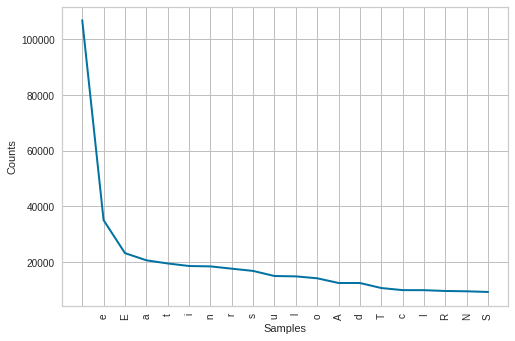

In [ ]:
fdist1.plot(20, cumulative=False)

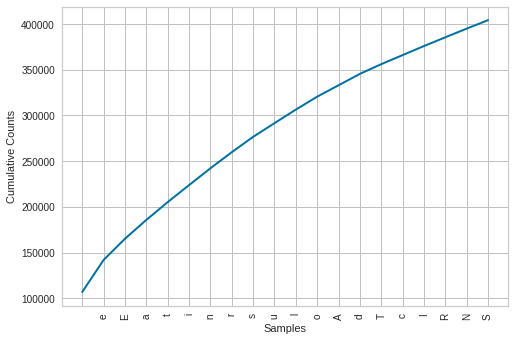

In [ ]:
# the top 20 characters cover more than 95% of all character occurrences in the corpus
fdist1.plot(20,cumulative=True)

In [ ]:
# the 10 most frequent characters in the corpus
#pd.DataFrame(fdist1.most_common(20))
fdist1.most_common(5)

[(' ', 106847), ('e', 35026), ('E', 23197), ('a', 20619), ('t', 19478)]

*Observations & conclusions*
- Type of characters: french letters, digits, punctuation, and white space.
- No special characters requiring special normalization/preprocessing (such as special encoded characters).
- No extraneous/noisy characters that should be removed prior to language identification (such as math symbols, emoticons and urls).

*****

## Text Preprocessing & Cleaning

Pipeline:
1. Language identification
2. Sentence segmentation
3. Remove non-word characters
4. Convert to lowercase
5. Tokenization
6. Stemming (simple heuristic for word normalization)
7. Spelling correction

### Sentence segmentation
Split the documents into sentences.

#### EDA

In [ ]:
for c in ['.','!','?']:
    print(c,fdist1[c])

. 2761
! 0
? 0


In [ ]:
import nltk
nltk.download('punkt')
L1 = [len(doc) for doc in corpus_df.content]
L2 = [len(sent_tokenize(doc)) for doc in corpus_df.content]
doc_len_df_ = pd.DataFrame({'n_chars' : L1, 'n_sents' : L2, \
                            'n_chars_per_sent' : np.array(L1)/np.array(L2)})
doc_len_df_.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,n_chars,n_sents,n_chars_per_sent
0,2285,2,1142.5
1,10554,5,2110.8
2,3723,5,744.6
3,5276,2,2638.0
4,2038,1,2038.0


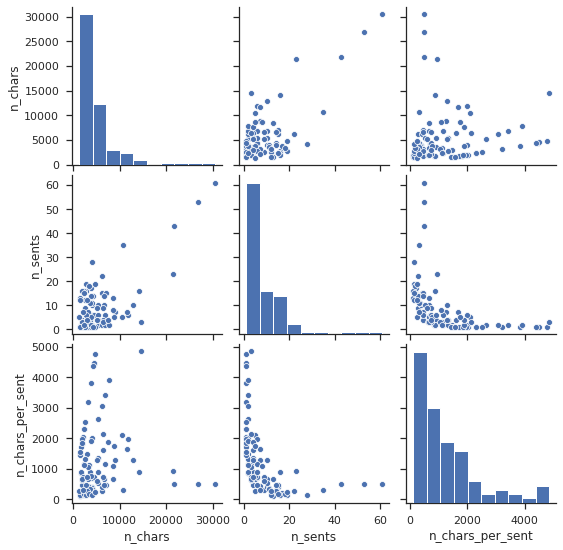

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(doc_len_df_)

#### Create corpus of sentences

In [ ]:
corpus_sentences_ = [sent_tokenize(doc) for doc in corpus_df.content]
len(corpus_sentences_),corpus_sentences_[0]

(100,
 ["SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X ..., ASSUREE SOCIALE , A PERCU LES INDEMNITES JOURNALIERES DE L ' ASSURANCE MALADIE DU 6 JUIN AU 25 SEPTEMBRE 1966 ET QU ' ELLE A REPRIS SON TRAVAIL A PLEIN TEMPS DU 26 SEPTEMBRE AU 28 OCTOBRE 1966 INCLUS ; QU ' A LA SUITE DE TROIS JOURS CHOMES ( 29 - 30 - 31 OCTOBRE ) ET D ' UN JOUR FERIE PAYE N ' AYANT PAS ENTRAINE LE PAIEMENT D ' INDEMNITES JOURNALIERES AU TITRE DE LA MALADIE ( 1ER NOVEMBRE ), ELLE N ' A PLUS , A COMPTER DU 2 NOVEMBRE 1966 , TRAVAILLE QU ' A MI - TEMPS , SUR PRESCRIPTION MEDICALE , JUSQU ' AU 18 DECEMBRE 1966 , DATE A LAQUELLE ELLE A REPRIS SON TRAVAIL A TEMPS COMPLET ; ATTENDU QU ' IL EST FAIT GRIEF A LA SENTENCE ATTAQUEE D ' AVOIR REFUSE A DEMOISELLE X ...",
  "LE BENEFICE DES INDEMNITES JOURNALIERES POUR LA PERIODE AU COURS DE LAQUELLE ELLE AVAIT TRAVAILLE A MI - TEMPS , AU MOTIF QUE LA REPRISE DU TRAVAIL A MI - TEMPS ETAIT INTERVENUE MOINS DE TROIS JOURS APRES LA CESSATION DU TRAVAIL , ALORS QUE LES TEXTES 

In [ ]:
u = [(sent,corpus_df.solution[i]) for i,doc in enumerate(corpus_sentences_) for sent in doc]
corpus_sent_df = pd.DataFrame(u)
corpus_sent_df.columns = ['sentence','solution']
assert(len(corpus_df)<=len(corpus_sent_df))
len(corpus_df),len(corpus_sent_df)

(100, 856)

In [ ]:
corpus_sent_df.head()

,sentence,solution
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet
1,LE BENEFICE DES INDEMNITES JOURNALIERES POUR L...,rejet
2,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet
3,"LA COUR , Vu les mémoires produits en demande ...",rejet
4,16 § 3 ) & quot ; ; Attendu qu ' il appert de ...,rejet


### Tokenization
- convert to lowercase.
- convert corpus to list of words
- throw away all non-letter characters (in our case digits and punctuation)

In [ ]:
tokenizer = RegexpTokenizer('[^_\W0-9]+')

In [ ]:
# convert to lowercase and tokenize
corpus_tokens_ = [tokenizer.tokenize(doc.lower()) for doc in corpus_sent_df.sentence]
assert(len(corpus_tokens_)==len(corpus_sent_df))
corpus_tokens_[0:5]

[['sur',
  'le',
  'moyen',
  'unique',
  'attendu',
  'que',
  'demoiselle',
  'x',
  'assuree',
  'sociale',
  'a',
  'percu',
  'les',
  'indemnites',
  'journalieres',
  'de',
  'l',
  'assurance',
  'maladie',
  'du',
  'juin',
  'au',
  'septembre',
  'et',
  'qu',
  'elle',
  'a',
  'repris',
  'son',
  'travail',
  'a',
  'plein',
  'temps',
  'du',
  'septembre',
  'au',
  'octobre',
  'inclus',
  'qu',
  'a',
  'la',
  'suite',
  'de',
  'trois',
  'jours',
  'chomes',
  'octobre',
  'et',
  'd',
  'un',
  'jour',
  'ferie',
  'paye',
  'n',
  'ayant',
  'pas',
  'entraine',
  'le',
  'paiement',
  'd',
  'indemnites',
  'journalieres',
  'au',
  'titre',
  'de',
  'la',
  'maladie',
  'er',
  'novembre',
  'elle',
  'n',
  'a',
  'plus',
  'a',
  'compter',
  'du',
  'novembre',
  'travaille',
  'qu',
  'a',
  'mi',
  'temps',
  'sur',
  'prescription',
  'medicale',
  'jusqu',
  'au',
  'decembre',
  'date',
  'a',
  'laquelle',
  'elle',
  'a',
  'repris',
  'son',
  'trav

In [ ]:
corpus_sent_df['tokenized_sent'] = corpus_tokens_
corpus_sent_df.head()

,sentence,solution,tokenized_sent
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet,"[sur, le, moyen, unique, attendu, que, demoise..."
1,LE BENEFICE DES INDEMNITES JOURNALIERES POUR L...,rejet,"[le, benefice, des, indemnites, journalieres, ..."
2,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet,"[rejet, du, pourvoi, formé, par, x, jean, fran..."
3,"LA COUR , Vu les mémoires produits en demande ...",rejet,"[la, cour, vu, les, mémoires, produits, en, de..."
4,16 § 3 ) & quot ; ; Attendu qu ' il appert de ...,rejet,"[quot, attendu, qu, il, appert, de, l, arrêt, ..."


In [ ]:
## Which documents are empty?
[corpus_sent_df.sentence[i] for i,doc in enumerate(corpus_tokens_) if len(doc)==0]

['876 .',
 '400 .',
 '495 .',
 '89 .',
 '165 .',
 '215 .',
 '688 .',
 '853 .',
 '127 .',
 '304 .',
 '60 .',
 '082 .',
 '083 .',
 '011 .',
 '012 .',
 '657 .',
 '531 .',
 '968 .',
 '653 .',
 '896 .',
 '.',
 '332 .',
 '463 .',
 '.',
 '.',
 '605 .',
 '586 .',
 '274 .',
 '131 .',
 '284 .',
 '714 .',
 '30 .',
 '82 .']

In [ ]:
## Word frequency distribution
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist2 = FreqDist(corpus_words_)
fdist2.N(),fdist2.B()

(86029, 6427)

In [ ]:
fdist2.most_common(10)

[('de', 5063),
 ('la', 3431),
 ('l', 2630),
 ('que', 2013),
 ('le', 1982),
 ('d', 1893),
 ('du', 1886),
 ('et', 1719),
 ('en', 1545),
 ('a', 1442)]

### Fix common orthographic errors
- 'œ' --> 'oe'

**TO BE FINISHED ...**

In [ ]:
# strange characters
#for c in ['ù', 'û', 'ô', 'â', 'î', 'ù', '5', '1', '3']:
#    print(c,fdist1[c])

In [ ]:
fdist1['œ'],len('œ')

(0, 1)

In [ ]:
fdist1['à'],fdist1['a']

(1181, 20619)

In [ ]:
fdist2['à'],fdist2['a']

(1165, 1442)

### Remove stopwords
We will use NLTK's default list of stop worsd for the French language.

#### Load standard list of stop words

In [ ]:
# Load NLTK stop words
import nltk
nltk.download('stopwords')
stop_words_fr = stopwords.words('french')
stop_words_fr = set(stop_words_fr)
len(stop_words_fr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


157

In [ ]:
#we can also add an entire list of words
stop_words_fr = stop_words_fr |  {'celle', 'celles', 'certain', 'certains', 'les','ils', 'elles', 'avoir', 'être', 'parce','où','si','chaque','donc','dont','encore','faut','quand','tant','tel','va','ici', 'ça'}
len(stop_words_fr)

178

In [ ]:
stop_words_fr = stop_words_fr - {'ne', 'pas'}
len(stop_words_fr)

176

#### EDA - Customize stop words to current corpus

In [ ]:
# Visually inspect words that are common in the corpus but are not in our stopwords list
u1 = pd.DataFrame([(word,freq) for word,freq in fdist2.most_common(100) if word not in stop_words_fr])
u1.columns = ['word', 'frequency']
len(u1)

51

In [ ]:
u1.sort_values('frequency', ascending=False).head(30)

,word,frequency
0,a,1442
1,pas,564
2,cour,524
3,appel,445
4,article,434
5,ne,421
6,attendu,413
7,code,391
8,x,363
9,arrêt,350


In [ ]:
# Visually inspect words that are stopwords and are sufficiently common in this corpus
u2 = pd.DataFrame([(word,fdist2[word]) for word in stop_words_fr if fdist2[word]>=3])
u2.columns = ['word', 'frequency']
len(u2)

90

In [ ]:
u2.sort_values('frequency', ascending=False).head(35)

,word,frequency
33,de,5063
26,la,3431
58,l,2630
51,que,2013
22,le,1982
4,d,1893
9,du,1886
68,et,1719
49,en,1545
89,à,1165


In [ ]:
## No words to remove from stopwords!


#### Remove stopwords from corpus

In [ ]:
# Finally remove stop words from our corpus
u = [[word for word in sent if word not in stop_words_fr] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)
corpus_sent_df.head()

,sentence,solution,tokenized_sent
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet,"[moyen, unique, attendu, demoiselle, x, assure..."
1,LE BENEFICE DES INDEMNITES JOURNALIERES POUR L...,rejet,"[benefice, indemnites, journalieres, periode, ..."
2,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet,"[rejet, pourvoi, formé, x, jean, françois, soc..."
3,"LA COUR , Vu les mémoires produits en demande ...",rejet,"[cour, vu, mémoires, produits, demande, défens..."
4,16 § 3 ) & quot ; ; Attendu qu ' il appert de ...,rejet,"[quot, attendu, appert, arrêt, attaqué, x, per..."


In [ ]:
# Which documents became empty after removing stopwords?
[(i,row.sentence) for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]

[(8, 'N ° 58 - 12 897 .'),
 (23, '876 .'),
 (50, '400 .'),
 (66, '495 .'),
 (76, '89 .'),
 (78, '165 .'),
 (81, '215 .'),
 (93, '688 .'),
 (99, '853 .'),
 (107, 'Y ...'),
 (110, '127 .'),
 (113, '304 .'),
 (116, '60 .'),
 (121, '11 et L .'),
 (122, '11 - 1 à L .'),
 (125, '11 à L .'),
 (151, '5 et 6 ).'),
 (194, '283 , L .'),
 (244, 'N ° 62 - 11 556 .'),
 (261, 'N 63 - 40 .'),
 (262, '082 .'),
 (274, 'N 63 - 40 .'),
 (275, '083 .'),
 (283, '011 .'),
 (293, '012 .'),
 (296, '657 .'),
 (307, 'N ° 61 - 40 453 .'),
 (331, 'N ° 60 - 10 420 .'),
 (340, 'N 58 - 12 .'),
 (341, '531 .'),
 (380, '244 - 2 , L .'),
 (389, '244 - 2 , L .'),
 (398, '244 - 7 et L .'),
 (404, '244 - 2 , L .'),
 (411, '968 .'),
 (423, '653 .'),
 (427, '132 - 5 - 1 et L .'),
 (430, '132 - 5 - 1 et L .'),
 (434, '132 - 5 - 1 et L .'),
 (436, '366 et 05 - 12 .'),
 (440, '132 - 5 - 1 et L .'),
 (456, '132 - 5 - 1 et L .'),
 (461, '132 - 5 - 1 et L .'),
 (463, '132 - 5 - 1 et L .'),
 (471, 'L .'),
 (478, 'N ° 62 - 12 460 .'

In [ ]:
corpus_sent_df.iloc[390,:]

sentence          244 - 3 , R 244 - 1 du Code de la sécurité soc...
solution                                                      rejet
tokenized_sent    [r, code, sécurité, sociale, pas, nature, cont...
Name: 390, dtype: object

### Clean up words based on word length
- will first get an idea about which words are unusually short or long.
- Very short words are usually not very meaningful; might be stopwords or abbreviations of some sort --> usually should be removed.
- Very long words are rare or meaningless or concatenations of multiple words, elongated words --> usually should be removed or normalized/stemmed.

In [ ]:
# create list of all words in corpus
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
type(corpus_words_),len(corpus_words_)

(list, 46411)

In [ ]:
word_len_df_ = pd.Series([len(word) for word in corpus_words_],index=corpus_words_)
word_len_df_.head()

moyen          5
unique         6
attendu        7
demoiselle    10
x              1
dtype: int64

In [ ]:
word_len_df_.describe()

count    46411.000000
mean         6.519080
std          2.774627
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         21.000000
dtype: float64

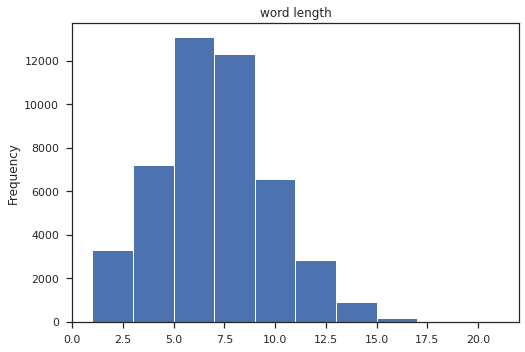

In [ ]:
fig = word_len_df_.plot(kind='hist', title="word length")

In [ ]:
# words with <= 2 characters
word_len_df_[word_len_df_<=2].value_counts()

1    2000
2    1284
dtype: int64

In [ ]:
word_len_df_[word_len_df_<=2].head()

x    1
a    1
a    1
a    1
a    1
dtype: int64

In [ ]:
# Remove words with <= 2 characters
u = [[word for word in sent if len(word)>2] for sent in corpus_sent_df.tokenized_sent]
assert(len(u) == len(corpus_sent_df))
corpus_sent_df.tokenized_sent = pd.Series(u)
corpus_sent_df.head()

,sentence,solution,tokenized_sent
0,SUR LE MOYEN UNIQUE : ATTENDU QUE DEMOISELLE X...,rejet,"[moyen, unique, attendu, demoiselle, assuree, ..."
1,LE BENEFICE DES INDEMNITES JOURNALIERES POUR L...,rejet,"[benefice, indemnites, journalieres, periode, ..."
2,REJET du pourvoi formé par : - X ... Jean - Fr...,rejet,"[rejet, pourvoi, formé, jean, françois, sociét..."
3,"LA COUR , Vu les mémoires produits en demande ...",rejet,"[cour, mémoires, produits, demande, défense, p..."
4,16 § 3 ) & quot ; ; Attendu qu ' il appert de ...,rejet,"[quot, attendu, appert, arrêt, attaqué, percut..."


In [ ]:
# Which documents became empty after removing short words?
[(i,row.sentence) for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]

[(8, 'N ° 58 - 12 897 .'),
 (22, 'NO 60 - 10 .'),
 (23, '876 .'),
 (50, '400 .'),
 (65, 'NO 62 - 12 .'),
 (66, '495 .'),
 (75, '1963 , II , NO 121 , P .'),
 (76, '89 .'),
 (78, '165 .'),
 (80, 'NO 62 - 20 .'),
 (81, '215 .'),
 (92, '1963 , IV , NO 834 , P .'),
 (93, '688 .'),
 (98, 'NO 60 - 12 .'),
 (99, '853 .'),
 (107, 'Y ...'),
 (109, '1961 , I , NO 159 , P .'),
 (110, '127 .'),
 (112, '1955 , I , NO 373 ( 4E ), P .'),
 (113, '304 .'),
 (115, '1962 , I , NO 67 , P .'),
 (116, '60 .'),
 (121, '11 et L .'),
 (122, '11 - 1 à L .'),
 (125, '11 à L .'),
 (138, '000 € H .'),
 (151, '5 et 6 ).'),
 (159, '000 € H .'),
 (181, '000 € H .'),
 (194, '283 , L .'),
 (244, 'N ° 62 - 11 556 .'),
 (261, 'N 63 - 40 .'),
 (262, '082 .'),
 (274, 'N 63 - 40 .'),
 (275, '083 .'),
 (282, 'NO 64 - 60 .'),
 (283, '011 .'),
 (284, 'X ... C / Y ...'),
 (292, 'NO 64 - 60 .'),
 (293, '012 .'),
 (296, '657 .'),
 (307, 'N ° 61 - 40 453 .'),
 (331, 'N ° 60 - 10 420 .'),
 (340, 'N 58 - 12 .'),
 (341, '531 .'),
 (37

In [ ]:
## Word frequency distribution
corpus_words_ = [word for sent in corpus_sent_df.tokenized_sent for word in sent]
fdist3 = FreqDist(corpus_words_)
assert(fdist3.N()<fdist2.N() and fdist3.B()<=fdist3.B())
print(fdist2.N(),fdist2.B())
print(fdist3.N(),fdist3.B())

86029 6427
43127 6267


*Observations & conclusions*
- Most short words are either stopwords or non-french words (english or tunisian dialect).

### Word normalization via stemming

#### Implement stemming algorithm
Apply Snowball stemming method from NLTK on words with 5 characters or more.

In [ ]:
stemmer = FrenchStemmer()

In [ ]:
def my_stemmer(word):
    if len(word)>4:
        stem1 = stemmer.stem(word)
        return stem1[0:8]
    else:
        return word

#### Visualize stemming results
Look for percent reduction in number of distinct words ...

In [ ]:
# put stemming results in a data frame
distinct_corpus_words_ = set([word for sent in corpus_sent_df.tokenized_sent for word in sent]) # set of all words in corpus

u = [(len(word),len(my_stemmer(word))) for word in distinct_corpus_words_]
u = [(x,y,x-y) for x,y in u]
word_stemming_df_ = pd.DataFrame(u,index=distinct_corpus_words_)
word_stemming_df_.columns = ['word_length', 'stem_length', 'length_reduction']
print(word_stemming_df_.shape)
word_stemming_df_.head()

(6267, 3)


,word_length,stem_length,length_reduction
roubaix,7,7,0
transfert,9,8,1
incompétentes,13,8,5
joignant,8,5,3
ravivasec,9,8,1


In [ ]:
# Visually inspect words that we did not stem
# word_stemming_df_[word_stemming_df_.word_length<=4]

In [ ]:
# Largest word length reduction
word_stemming_df_.sort_values('length_reduction', ascending=False).head()

,word_length,stem_length,length_reduction
reconventionnellement,21,8,13
interprofessionnelle,20,8,12
conventionnellement,19,8,11
embellissements,15,5,10
contradictoirement,18,8,10


In [ ]:
# Longest words after stemming
word_stemming_df_.sort_values('stem_length', ascending=False).head()

,word_length,stem_length,length_reduction
interruptifs,12,8,4
demoiselle,10,8,2
grossesse,9,8,1
tonnellerie,11,8,3
sanitaires,10,8,2


In [ ]:
# Shortest words after stemming
word_stemming_df_[word_stemming_df_.length_reduction>0].sort_values('word_length', ascending=True).head()

,word_length,stem_length,length_reduction
zones,5,3,2
vider,5,3,2
fonds,5,4,1
louis,5,3,2
terme,5,4,1


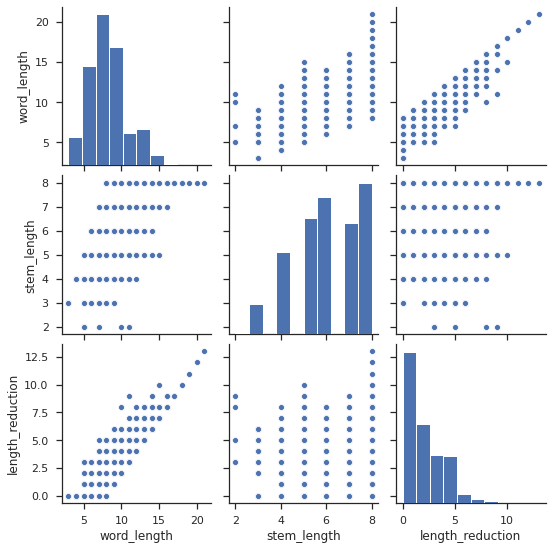

In [ ]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(word_stemming_df_)

### Remove empty documents

In [ ]:
len(corpus_sent_df)

856

In [ ]:
# which documents are empty
idx = [i for i,row in corpus_sent_df.iterrows() if len(row.tokenized_sent)==0]
#len(idx),len(corpus_sent_df)
corpus_sent_df.iloc[idx,:]

,sentence,solution,tokenized_sent
8,N ° 58 - 12 897 .,cassation,[]
22,NO 60 - 10 .,cassation,[]
23,876 .,cassation,[]
50,400 .,rejet,[]
65,NO 62 - 12 .,cassation,[]
...,...,...,...
796,"457 ), que M .",rejet,[]
823,122 - 32 - 6 et L .,cassation,[]
828,122 - 8 et L .,cassation,[]
843,X ...,cassation,[]


In [ ]:
corpus_sent_df = corpus_sent_df[corpus_sent_df.apply(lambda row: len(row['tokenized_sent'])>0,axis=1)]
len(corpus_sent_df)

731

***

## Exploratory Analysis of document length distribution
Get a general idea about corpus content. Things to look for:
- Are documents homogeneous in terms of size?
- Are there any outliers that should be removed from corpus?

In [ ]:
L1 = [len(doc) for doc in corpus_sent_df.tokenized_sent]
L2 = [len(' '.join(doc)) for doc in corpus_sent_df.tokenized_sent]
doc_len_df_ = pd.DataFrame({'n_words' : L1, \
                           'n_chars' : L2, \
                           'n_chars_per_word' : np.array(L2)/np.array(L1)})
doc_len_df_.head()

,n_words,n_chars,n_chars_per_word
0,58,453,7.810345
1,135,1037,7.681481
2,47,378,8.042553
3,185,1480,8.000000
4,216,1742,8.064815


In [ ]:
doc_len_df_.describe()

,n_words,n_chars,n_chars_per_word
count,731.000000,731.000000,731.000000
mean,58.997264,465.642955,7.623365
std,98.498592,781.118901,1.076904
min,1.000000,3.000000,3.000000
25%,4.000000,34.000000,7.222222
50%,19.000000,146.000000,7.766667
75%,64.000000,508.000000,8.137413
max,730.000000,5591.000000,10.250000


In [ ]:
#doc_len_df_.corr()

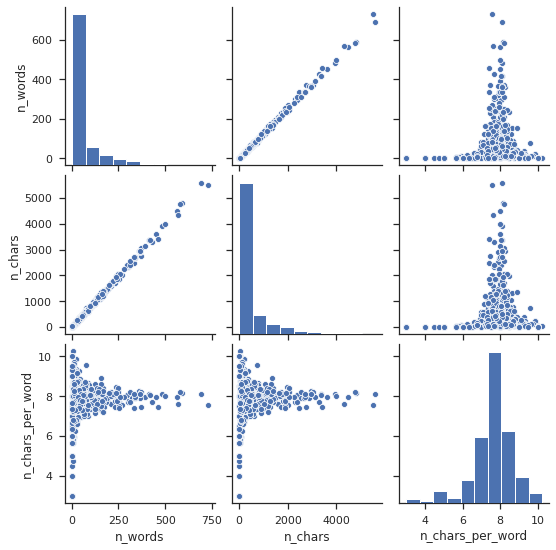

In [ ]:
g = sns.pairplot(doc_len_df_)

In [ ]:
# documents that contain only one word
#corpus_sent_df.tokenized_sent[doc_len_df_.n_words==1]
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==1]).value_counts().head(10)

president     12
avocats       10
rapporteur    10
rejet          4
ops            4
vigneron       3
point          3
autres         3
brunhes        2
iii            2
dtype: int64

In [ ]:
# documents that contain 2 words
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==2]).value_counts().head(10)

avocat general          11
janvier bull             2
drouillat rapporteur     2
mars bull                1
nicolay sueur            1
decembre bull            1
guillot rapporteur       1
brt rousseau             1
schmelck avocats         1
avril bull               1
dtype: int64

In [ ]:
# documents that contain 3 words
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)==3]).value_counts().head(10)

memes especes mai          2
rapprocher mai bull        2
rapprocher fevrier bull    2
societe general motors     2
alban chaix président      2
crespin avocat general     1
pelletier mme ponroy       1
rapprocher juin bull       1
ryziger chaise martin      1
gall mme chanet            1
dtype: int64

In [ ]:
pd.Series([' '.join(doc) for doc in corpus_sent_df.tokenized_sent if len(doc)>20])

0      moyen unique attendu demoiselle assuree social...
1      benefice indemnites journalieres periode cours...
2      rejet pourvoi formé jean françois société quot...
3      cour mémoires produits demande défense premier...
4      quot attendu appert arrêt attaqué percuté plei...
                             ...                        
346    attendu selon arrêt attaqué paris octobre prod...
347    directeur publication journal société nouvelle...
348    snpc invoqué moyen pris prescription action as...
349    snpc déposé conclusions fond novembre soulevé ...
350    snpc pas renoncé invoquer moyen bien pas soule...
Length: 351, dtype: object

*Observations & conclusions*
- overall very long documents; We should reduce the size of the text for input for the machine learning algorithms


******

## Exploratory Analysis of Word Frequency Distribution

- Analyze and visualize frequency distribution of words across entire corpus and across indivudal documents.
- Are there stopwords among most frequent words?
- might help us determine how to represent documents (using TF or TF\*IDF).

*Observations & conclusions*
- corpus contains 1311 unique/distinct words.
- 52% of words are *hapaxes* (words that occur only once in entire corpus).
- 30 most common words account for ~30% of all word occurrences.
- Word distribution seems to follow the typical Zipf distribution.

****

## Collocation Detection
- Distribution of Word Bigrams and Trigrams.
- Are there any frequent bigrams or trigrams?
- Should we use Bag-of-ngrams model with n>1 ?

**To be finished ...**

Collocations I have noticed in this corpus:
- Main d'oeuvre
- Je ne sais pas


In [ ]:
from nltk import collocations

In [ ]:
u = [[word for word in doc] + ['.'] for doc in corpus_sent_df.tokenized_sent]
u[0:3]

[['moyen',
  'unique',
  'attendu',
  'demoiselle',
  'assuree',
  'sociale',
  'percu',
  'indemnites',
  'journalieres',
  'assurance',
  'maladie',
  'juin',
  'septembre',
  'repris',
  'travail',
  'plein',
  'temps',
  'septembre',
  'octobre',
  'inclus',
  'suite',
  'trois',
  'jours',
  'chomes',
  'octobre',
  'jour',
  'ferie',
  'paye',
  'pas',
  'entraine',
  'paiement',
  'indemnites',
  'journalieres',
  'titre',
  'maladie',
  'novembre',
  'plus',
  'compter',
  'novembre',
  'travaille',
  'temps',
  'prescription',
  'medicale',
  'jusqu',
  'decembre',
  'date',
  'laquelle',
  'repris',
  'travail',
  'temps',
  'complet',
  'attendu',
  'fait',
  'grief',
  'sentence',
  'attaquee',
  'refuse',
  'demoiselle',
  '.'],
 ['benefice',
  'indemnites',
  'journalieres',
  'periode',
  'cours',
  'laquelle',
  'travaille',
  'temps',
  'motif',
  'reprise',
  'travail',
  'temps',
  'etait',
  'intervenue',
  'moins',
  'trois',
  'jours',
  'apres',
  'cessation',
  

In [ ]:
corpus_words_list_with_separator = [word for doc in u for word in doc]
# corpus_words_list_with_separator[0:10]

In [ ]:
bigram_measures = collocations.BigramAssocMeasures()
bigram_finder = collocations.BigramCollocationFinder.from_words(corpus_words_list_with_separator)

In [ ]:
# number of unique bigrams
len(bigram_finder.score_ngrams(bigram_measures.raw_freq))

26753

In [ ]:
# most frequent bigrams
bigram_finder.nbest(bigram_measures.raw_freq, 10)

[('cour', 'appel'),
 ('clear', 'none'),
 ('article', 'code'),
 ('code', 'civil'),
 ('code', 'procédure'),
 ('none', 'clear'),
 ('.', 'code'),
 ('arrêt', 'attaqué'),
 ('cour', 'cassation'),
 ('procédure', 'civile')]

In [ ]:
bigram_finder.nbest(bigram_measures.likelihood_ratio, 10)

[('cour', 'appel'),
 ('clear', 'none'),
 ('code', 'civil'),
 ('article', 'code'),
 ('code', 'procédure'),
 ('none', 'clear'),
 ('arrêt', 'attaqué'),
 ('procédure', 'civile'),
 ('casse', 'annule'),
 ('dès', 'lors')]

In [ ]:
bigram_finder.nbest(bigram_measures.pmi, 10)

[('abord', 'indemnisant'),
 ('aboutir', 'depouillement'),
 ('abstention', 'caractérisait'),
 ('acca', 'nieul'),
 ('accorder', 'liberalite'),
 ('accords', 'passes'),
 ('actiion', 'edictees'),
 ('activement', 'evite'),
 ('affiliées', 'obligatoirement'),
 ('affirmative', 'homologuant')]

In [ ]:
bigram_finder.nbest(bigram_measures.chi_sq, 10)

[('abord', 'indemnisant'),
 ('aboutir', 'depouillement'),
 ('abstention', 'caractérisait'),
 ('acca', 'nieul'),
 ('accorder', 'liberalite'),
 ('accords', 'passes'),
 ('actiion', 'edictees'),
 ('actionnaire', 'majoritaire'),
 ('activement', 'evite'),
 ('activites', 'secondaires')]

In [ ]:
bigram_finder.nbest(bigram_measures.dice, 10)

[('abord', 'indemnisant'),
 ('aboutir', 'depouillement'),
 ('abstention', 'caractérisait'),
 ('acca', 'nieul'),
 ('accorder', 'liberalite'),
 ('accords', 'passes'),
 ('actiion', 'edictees'),
 ('actionnaire', 'majoritaire'),
 ('activement', 'evite'),
 ('activites', 'secondaires')]

In [ ]:
bigram_finder.nbest(bigram_measures.jaccard, 10)

[('abord', 'indemnisant'),
 ('aboutir', 'depouillement'),
 ('abstention', 'caractérisait'),
 ('acca', 'nieul'),
 ('accorder', 'liberalite'),
 ('accords', 'passes'),
 ('actiion', 'edictees'),
 ('actionnaire', 'majoritaire'),
 ('activement', 'evite'),
 ('activites', 'secondaires')]

In [ ]:
bigram_finder.nbest(bigram_measures.mi_like, 10)

[('cour', 'appel'),
 ('clear', 'none'),
 ('casse', 'annule'),
 ('code', 'civil'),
 ('dès', 'lors'),
 ('none', 'clear'),
 ('siana', 'cdm'),
 ('code', 'procédure'),
 ('procédure', 'civile'),
 ('audience', 'publique')]

In [ ]:
# Remove bigrams that occur less than 10 times
bigram_finder.apply_freq_filter(10)
len(bigram_finder.score_ngrams(bigram_measures.raw_freq))

351

In [ ]:
trigram_measures = collocations.TrigramAssocMeasures()
trigram_finder = collocations.TrigramCollocationFinder.from_words(corpus_words_list_with_separator)

In [ ]:
# number of unique trigrams
len(trigram_finder.score_ngrams(trigram_measures.raw_freq))

33443

In [ ]:
trigram_finder.apply_freq_filter(3)

In [ ]:
len(trigram_finder.score_ngrams(trigram_measures.raw_freq))

1551

In [ ]:
# most frequent trigrams
trigram_finder.nbest(trigram_measures.raw_freq, 10)

[('clear', 'none', 'clear'),
 ('none', 'clear', 'none'),
 ('article', 'code', 'civil'),
 ('code', 'procédure', 'civile'),
 ('cour', 'appel', 'violé'),
 ('article', '.', 'code'),
 ('droit', 'renvoie', 'devant'),
 ('fait', 'droit', 'renvoie'),
 ('nouveau', 'code', 'procédure'),
 ('devant', 'cour', 'appel')]

*Observations & Conclusions*
- A few trigrams but no bigrams within the same document.
- Hence Bag-of-ngrams model with n=2 seems adequate.


CONCLUSION : 

In this notebook, The semantic aspects of the data set of jurisprudences used in the realization of the classifier was studied.

Some information concerning the use of the TF-IDFweightning  which will be applicable on this database is identified:(preprocessing text, text truncation .
.. ) 

******